In [144]:
cd ../analysis/

/home/jlee782/final_segmentation/analysis


In [145]:
%pylab inline
%load_ext autoreload
%autoreload 2
from baseline import *

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
def compute_best_average_heuristics_workers_baselines():
    metric_keys = ['Precision [Self]', u'Recall [Self]','Jaccard [Self]','FPR [Self]','FNR [Self]']
    computed_wrt_gt = pd.read_csv("../data/computed_my_COCO_BBvals.csv",index_col=0)
    computed_wrt_gt=computed_wrt_gt[computed_wrt_gt["worker_id"]!=3]
    sample_lst = sample_specs.keys()
    obj_clusters = clusters()
    df_data =[]
    for batch in sample_lst:
        for objid in object_lst:
            if str(objid) in obj_clusters[batch]:
                clusts = ["-1"] + [obj_clusters[batch][str(objid)]]
            else:
                clusts = ["-1"]
            for clust in clusts:
                hydir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, batch, objid)
                if clust=="-1":
                    worker_ids = json.load(open(hydir+"worker_ids.json"))
                else:
                    worker_ids= json.load(open(hydir+"/clust{}/worker_ids.json".format(clust)))

                selected_annotations = computed_wrt_gt[(computed_wrt_gt["object_id"]==objid)&(computed_wrt_gt["worker_id"].isin(worker_ids))]
                best_num_pt_p,best_num_pt_r,best_num_pt_j,best_num_pt_fnr,best_num_pt_fpr = selected_annotations.loc[selected_annotations["Num Points"].idxmax()][metric_keys]
                best_ar_p,best_ar_r,best_ar_j,best_ar_fnr,best_ar_fpr = selected_annotations.loc[selected_annotations["Area Ratio"].idxmax()][metric_keys]
                max_p,max_r,max_j,max_fpr,max_fnr = selected_annotations.loc[selected_annotations["Jaccard [Self]"].idxmax()][metric_keys]
                avrg_p,avrg_r,avrg_j,avrg_fpr,avrg_fnr =  selected_annotations.mean()[metric_keys]
                df_data.append([batch, objid,clust, 
                                best_num_pt_p,best_num_pt_r,best_num_pt_j,best_num_pt_fnr,best_num_pt_fpr,\
                                 best_ar_p,best_ar_r,best_ar_j,best_ar_fnr,best_ar_fpr,\
                                avrg_p,avrg_r,avrg_j,avrg_fpr,avrg_fnr,max_p,\
                                max_r,max_j,max_fpr,max_fnr])
    df = pd.DataFrame(df_data,columns=["sample","objid","clust",
                    "P [NumPt]","R [NumPt]","J [NumPt]","FNR% [NumPt]","FPR% [NumPt]",
                    "P [AreaRatio]","R [AreaRatio]","J [AreaRatio]","FNR% [AreaRatio]","FPR% [AreaRatio]",
                    "P [AvrgWorker]","R [AvrgWorker]","J [AvrgWorker]","FNR% [AvrgWorker]","FPR% [AvrgWorker]",
                    "P [BestWorker]","R [BestWorker]","J [BestWorker]","FNR% [BestWorker]","FPR% [BestWorker]"])
    df["num_workers"]=df["sample"].apply(lambda x: int(x.split("workers")[0]))
    df.to_csv("pixel_em/individual_worker_performance.csv",index=None)
    return df

In [83]:
df = compute_best_average_heuristics_workers_baselines()

In [84]:
NworkerPerformance = df.groupby("num_workers").mean()

In [85]:
metric_J_baselines=["J [NumPt]","J [AreaRatio]","J [AvrgWorker]","J [BestWorker]"]

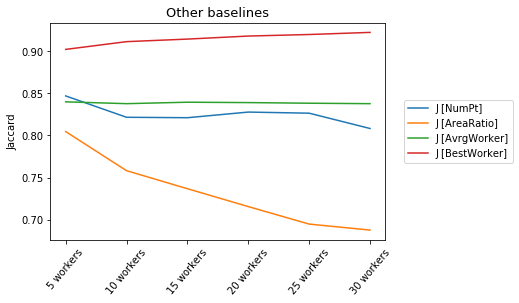

In [86]:
for algo in metric_J_baselines:
    plt.plot(np.array(NworkerPerformance[algo]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Other baselines",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])

In [117]:
from withClustAnalysis import *
best_clust_df = best_worker_picking()
clustObj=clust_df.objid.unique()
def plot_best_clust_thresh_metric(metric,gt="",includeObjs=[],plot_noClustMV=True):
    for algo in ['GTLSA',"basic","GT","isoGT","isoGTLSA"]:
        # we only ran on the best clusters, so the results should only be on the best clusters if not -1
        data =  pd.read_csv("pixel_em/{}{}_full_PRJ_table.csv".format(gt,algo))
        data = data[((data["clust"]==-1) &(data["objid"].isin(noClust_obj)))| ((data["clust"]!=-1) & data["objid"].isin(clustObj))]
        if includeObjs!=[]:
            data = data[data["objid"].isin(includeObjs)]
        #data = data[data["sample_num"]==0]
        plt.plot(np.array(data.groupby("num_workers").mean()[metric]),label=algo)
    print len(data.groupby("num_workers").mean()[metric])
    MV = pd.read_csv("pixel_em/MV_full_PRJ_table.csv") 
    #MV = MV[MV["sample_num"]==0]
    # now need to filter based on best cluster
    MV = filter_best_clust(MV,best_clust_df)
    if includeObjs!=[]:
        MV = MV[MV["objid"].isin(includeObjs)]
    # select only the best cluster if clustered object -1 if not clustered
    MV_withClust = MV[((MV["clust"]==-1) &(MV["objid"].isin(noClust_obj)))| ((MV["clust"]!=-1) & MV["objid"].isin(clustObj))]
    plt.plot(np.array(MV_withClust.groupby("num_workers").mean()[metric]),label="MV clust",color="cyan",linestyle="--")
    if plot_noClustMV:
        MV_noClust = MV[(MV["clust"]==-1) &(MV["objid"].isin(noClust_obj))].groupby("num_workers").mean()[metric]
        plt.plot(np.array(MV_noClust),label="MV no clust",color="black",linestyle="--")

    plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
    plt.ylabel(metric)
    plt.xticks(rotation=50)
    a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
    if gt:
        plt.title("Ground truth EM [best clust & thresh]",fontsize=13)
    else:
        plt.title("Binary Search Thresh EM [best clust & thresh]",fontsize=13)

6


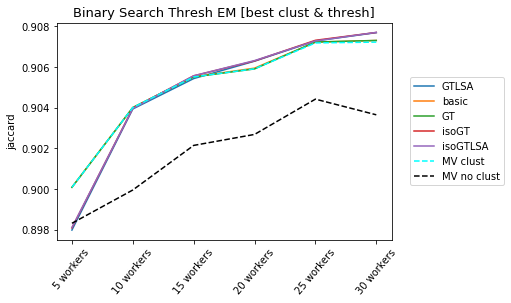

In [118]:
plot_best_clust_thresh_metric("jaccard")

6
6


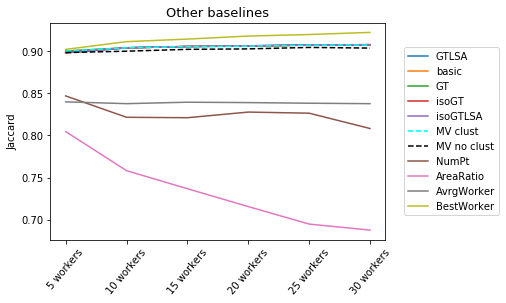

In [121]:
plot_best_clust_thresh_metric("jaccard")

for algo in metric_J_baselines:
    plt.plot(range(6),np.array(NworkerPerformance[algo]),label=algo[3:-1])
print len(np.array(NworkerPerformance[algo]))
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Other baselines",fontsize=13)


# gt-est by best worker picking based on worker quality, also correlation with individual worker

In [197]:
df = pd.read_csv("../data/computed_my_COCO_BBvals.csv",index_col=0)

In [198]:
df= df[df["worker_id"]!=3]

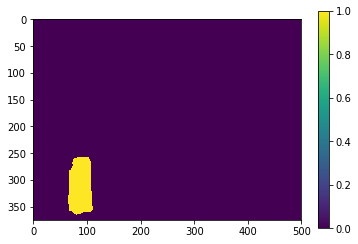

In [158]:
plt.imshow(pkl.load(open("pixel_em/obj22/mask24.pkl")))
plt.colorbar()

In [160]:
# pd.set_option('display.height', 500)
# pd.set_option('display.max_rows', 500)
# df[["object_id","worker_id","Jaccard [Self]","Precision [Self]","Recall [Self]"]]

In [161]:
for row in df.iterrows():
    row = row[1]
    row[["object_id","worker_id","Jaccard [Self]","Precision [Self]","Recall [Self]","FPR [Self]","FNR [Self]"]]

In [162]:
row[["object_id","worker_id","Jaccard [Self]","Precision [Self]","Recall [Self]","FPR [Self]","FNR [Self]"]]

object_id                    10
worker_id                   139
Jaccard [Self]        0.9484793
Precision [Self]      0.9805065
Recall [Self]         0.9667082
FPR [Self]          0.001097399
FNR [Self]           0.01921914
Name: 1946, dtype: object

In [200]:
df=pd.read_csv("../data/bounding_box.csv")

In [203]:
from analysis_toolbox import load_info
img_info,object_tbl,bb_info,hit_info = load_info()

/home/jlee782/.local/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [204]:
bb_info[bb_info["worker_id"]==2]

,object_id,worker_id,x_locs,y_locs
183,9,2,"[257, 353, 380, 383, 385, 309, 294, 284, 269, ...","[219, 191, 232, 252, 279, 288, 278, 269, 268, ..."
1891,12,2,"[304, 307, 308, 381, 394, 402, 402, 310]","[292, 311, 323, 439, 443, 440, 431, 301]"
1892,10,2,"[393, 411, 440, 472, 520, 541, 539, 537, 537, ...","[237, 228, 224, 225, 238, 257, 270, 278, 285, ..."


In [201]:
df[df["worker_id"]==2]

,object_id,worker_id,x_locs,y_locs
183,9,2,"[257, 353, 380, 383, 385, 309, 294, 284, 269, ...","[219, 191, 232, 252, 279, 288, 278, 269, 268, ..."
1891,12,2,"[304, 307, 308, 381, 394, 402, 402, 310]","[292, 311, 323, 439, 443, 440, 431, 301]"
1892,10,2,"[393, 411, 440, 472, 520, 541, 539, 537, 537, ...","[237, 228, 224, 225, 238, 257, 270, 278, 285, ..."


In [243]:
from qualityBaseline import *

In [244]:
img_info,object_tbl,bb_info,hit_info = load_info()

In [245]:
def compute_self_BBvals(compute_metrics=['simple','area','dist']):
    #compute_metrics=["Num Points", 'Precision [Self]','Recall [Self]','Jaccard [Self]',"NME [Self]","Area Ratio"]
    from analysis_toolbox import *
    from collections import OrderedDict
    '''
    Selectively compute metrics and store into computed_my_COCO_BBvals.csv
    'simple': simple baselines [Point,Size]
    'area': Area based metrics [Precision, Recall, Jaccard index]
    'distance': Distance based metrics [MunkresEuclidean]
    '''
    if len(compute_metrics)==3: print "Note: It will take about 2 hours to compute all metrics for all workers"
    save_db_as_csv(connect=False)
    #If we are recomputing everything, then load brand new bb_info table
    img_info,object_tbl,bb_info,hit_info = load_info()
    ground_truth = pd.read_csv("../data/object_ground_truth.csv")
    my_BBG  = pd.read_csv("../data/my_ground_truth.csv")

    for bb in tqdm(list(bb_info.iterrows())):

        oid = bb[1]["object_id"]
        #Image information
        image_id = int(object_tbl[object_tbl.object_id==oid].image_id)
        img_name = img_info["filename"][image_id-1]

        bbx_path= bb[1]["x_locs"]
        bby_path= bb[1]["y_locs"]
        worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
        worker_x_locs,worker_y_locs = zip(*list(OrderedDict.fromkeys(zip(worker_x_locs,worker_y_locs))))
        #Simple Baseline Measures
        if 'simple' in compute_metrics:
            bb_info = bb_info.set_value(bb[0],"Num Points",len(worker_x_locs))
            bb_info = bb_info.set_value(bb[0],"Area Ratio",compute_img_to_bb_area_ratio(img_name,worker_x_locs,worker_y_locs))
        if ('area' in compute_metrics) or ('dist' in compute_metrics):
            
            # Comparing with SELF ground truth
            my_ground_truth_match = my_BBG[my_BBG.object_id==oid]
            my_x_locs,my_y_locs =  process_raw_locs([my_ground_truth_match["x_locs"].iloc[0],my_ground_truth_match["y_locs"].iloc[0]])
            my_x_locs,my_y_locs = zip(*list(OrderedDict.fromkeys(zip(my_x_locs,my_y_locs))))
            obj_x_locs = [list(worker_x_locs),list(my_x_locs)]
            obj_y_locs = [list(worker_y_locs),list(my_y_locs)]
            if ('area' in compute_metrics):
                bb_info = bb_info.set_value(bb[0],"Jaccard [Self]",jaccard(obj_x_locs,obj_y_locs))
                bb_info = bb_info.set_value(bb[0],"Precision [Self]",precision(obj_x_locs,obj_y_locs))
                bb_info = bb_info.set_value(bb[0],"Recall [Self]",recall(obj_x_locs,obj_y_locs))
    #Drop Unnamed columns (index from rewriting same file)
    bb_info = bb_info[bb_info.columns[~bb_info.columns.str.contains('Unnamed:')]]
    # replace all NAN values with -1, these are entries for which we don't have COCO ground truth
    bb_info = bb_info.fillna(-1)
    bb_info.to_csv("computed_my_COCO_BBvals.csv")

<ipython-input-245-3563f89a7313>:1: SyntaxWarning: import * only allowed at module level
  def compute_self_BBvals(compute_metrics=['simple','area','dist']):


In [246]:
compute_self_BBvals(compute_metrics=['simple','area'])

In [238]:
def jaccard(obj_x_locs,obj_y_locs):
    '''
    Jaccard Simmilarity or Overlap Method
    used for PASCAL VOC challenge
    '''
    return intersection(obj_x_locs,obj_y_locs)/union(obj_x_locs,obj_y_locs)

In [251]:
df =pd.read_csv("../data/computed_my_COCO_BBvals.csv",index_col=0)

In [252]:
df[df["worker_id"]==2]

,object_id,worker_id,x_locs,y_locs,Num Points,Area Ratio,Jaccard [Self],Precision [Self],Recall [Self],F1 [COCO],...,FPR [Self],Jaccard [COCO],Precision [COCO],Recall [COCO],Union [COCO],Intersection [COCO],TPR [COCO],FNR [COCO],TNR [COCO],FPR [COCO]


In [195]:
df_data = []
for sample_name in sample_lst:
    for objid in object_lst:
        if str(objid) in obj_clusters[batch]:
            #clusts = ["-1"] + [obj_clusters[batch][str(objid)]]
            clusts = [obj_clusters[batch][str(objid)]]
        else:
            clusts = ["-1"]
        for cluster_id in clusts:
            if cluster_id!="" and cluster_id!="-1"  :
                outdir = '{}{}/obj{}/clust{}/'.format(PIXEL_EM_DIR, sample_name, objid,cluster_id)
            else:
                outdir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, sample_name, objid)
#             if clust=="-1":
#                 worker_ids = json.load(open(hydir+"worker_ids.json"))
#             else:
#                 worker_ids= json.load(open(hydir+"/clust{}/worker_ids.json".format(clust)))
            try:
                qj = pkl.load(open("{}Qj_best_thresh.pkl".format(outdir)))
            except(IOError):
                print "can not find:",outdir
            for wid,q in qj.iteritems():
                if len(df[(df["object_id"]==objid)&(df["worker_id"]==wid)])==0:
                    print "can not find in df:",objid,";worker:",wid
                else:
                    worker_performance = df[(df["object_id"]==objid)&(df["worker_id"]==wid)][["Jaccard [Self]","Precision [Self]","Recall [Self]","FPR [Self]","FNR [Self]"]].values[0]
                data = [sample_name,objid,clust,wid,q]
                data.extend(worker_performance)
                df_data.append(data)

can not find in df: 10 ;worker: 2
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/5workers_rand6/obj47/clust2/
can not find in df: 47 ;worker: 52
can not find in df: 12 ;worker: 2
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/5workers_rand5/obj47/clust2/
can not find in df: 47 ;worker: 193
can not find in df: 47 ;worker: 259
can not find in df: 10 ;worker: 2
can not find: /home/jlee782/final_segmentation/analysis/pixel_em/5workers_rand0/obj47/clust2/
can not find in df: 47 ;worker: 193
can not find in df: 47 ;worker: 259
can not find in df: 10 ;worker: 2
can not find in df: 12 ;worker: 2
can not find in df: 9 ;worker: 2
can not find in df: 9 ;worker: 2
can not find in df: 10 ;worker: 2
can not find in df: 12 ;worker: 2
can not find in df: 9 ;worker: 2
can not find in df: 10 ;worker: 2
can not find in df: 12 ;worker: 2
can not find in df: 9 ;worker: 2
can not find in df: 9 ;worker: 2
can not find in df: 10 ;worker: 2
can not find in df: 12 ;worker: 2


0

In [122]:
qj = pkl.load(open("pixel_em/10workers_rand0/obj1/Qj_best_thresh.pkl"))

In [139]:
for wid,q in qj.iteritems():
    print wid,q

118 0.997457682292
170 0.995234375
140 0.995891927083
239 0.998115234375
52 0.993450520833
149 0.997766927083
246 0.996282552083
248 0.993938802083
116 0.997415364583
182 0.997584635417


In [ ]:
ls pixel_em/10workers_rand0/obj1/Qj_best_thresh.pkl